##### Copyright 2018 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image captioning with visual attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/image_captioning">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Given an image like the example below, your goal is to generate a caption such as "a surfer riding on a wave".

![Man Surfing](https://tensorflow.org/images/surf.jpg)

*[Image Source](https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg); License: Public Domain*

To accomplish this, you'll use an attention-based model, which enables us to see what parts of the image the model focuses on as it generates a caption.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

The model architecture is similar to [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044).

This notebook is an end-to-end example. When you run the notebook, it downloads the [MS-COCO](http://cocodataset.org/#home) dataset, preprocesses and caches a subset of images using Inception V3, trains an encoder-decoder model, and generates captions on new images using the trained model.

In this example, you will train a model on a relatively small amount of data—the first 30,000 captions  for about 20,000 images (because there are multiple captions per image in the dataset).

In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

1 Physical GPUs, 1 Logical GPUs


## Download and prepare the MS-COCO dataset

You will use the [MS-COCO dataset](http://cocodataset.org/#home) to train your model. The dataset contains over 82,000 images, each of which has at least 5 different caption annotations. The code below downloads and extracts the dataset automatically.

**Caution: large download ahead**. You'll use the training set, which is a 13GB file.

In [3]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

In [4]:
annotation_file = os.path.abspath('.')+'/annotations/captions_train2014.json'

In [5]:
annotation_file

'C:\\Users\\vedpi/annotations/captions_train2014.json'

## Optional: limit the size of the training set 
To speed up training for this tutorial, you'll use a subset of 30,000 captions and their corresponding images to train your model. Choosing to use more data would result in improved captioning quality.

In [6]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [7]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [8]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:8000]
print(len(train_image_paths))

8000


In [9]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> a couple of people sit inside of a truck as people look on <end> <start> a very well made track moving on the street <end> <start> A very souped up pickup truck on a city street at night. <end> <start> a truck with odd patterns and designs on it <end> <start> A custom painted pickup truck in the street with onlookers. <end>


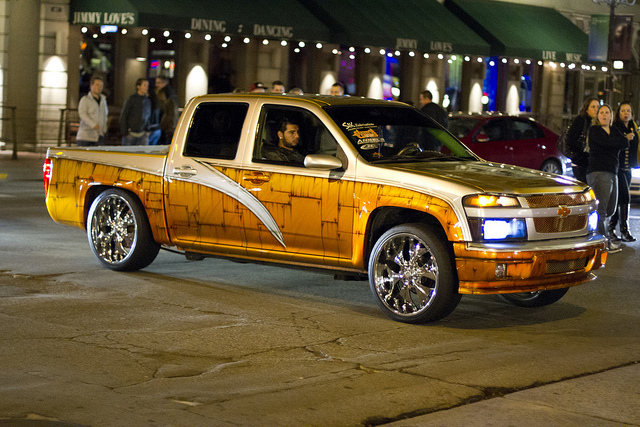

In [10]:
print(train_captions[10], train_captions[11], train_captions[12], train_captions[13], train_captions[14])
Image.open(img_name_vector[10])

<start> an image of a man in a suit standing next to a cow <end>


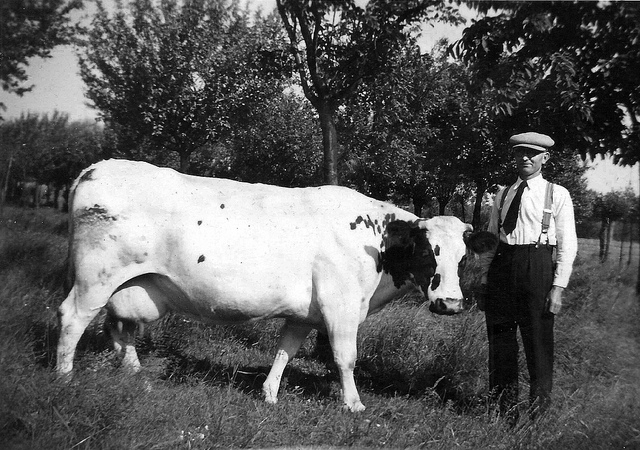

In [11]:
print(train_captions[0])
Image.open(img_name_vector[0])

## Preprocess the images using InceptionV3
Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into InceptionV3's expected format by:
* Resizing the image to 299px by 299px
* [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [12]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Initialize InceptionV3 and load the pretrained Imagenet weights

Now you'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is ```8x8x2048```. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

* You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, you save the dictionary to disk.


In [13]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [14]:
tf.keras.utils.plot_model(image_features_extract_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [15]:
hidden_layer

<KerasTensor: shape=(None, None, None, 2048) dtype=float32 (created by layer 'mixed10')>

## Caching the features extracted from InceptionV3

You will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 \* 8 \* 2048 floats per image. At the time of writing, this exceeds the memory limitations of Colab (currently 12GB of memory).

Performance could be improved with a more sophisticated caching strategy (for example, by sharding the images to reduce random access disk I/O), but that would require more code.

The caching will take about 10 minutes to run in Colab with a GPU. If you'd like to see a progress bar, you can: 

1. Install [tqdm](https://github.com/tqdm/tqdm):

    `!pip install tqdm`

2. Import tqdm:

    `from tqdm import tqdm`

3. Change the following line:

    `for img, path in image_dataset:`

    to:

    `for img, path in tqdm(image_dataset):`


In [16]:
check_dir = r"C:\Users\vedpi\train2014"

In [17]:
to_delete = [name for name in os.listdir(check_dir) if ".npy" in name]

In [18]:
for f in to_delete:
    os.remove(check_dir + "/" + f)

In [19]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(128)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

## Preprocess and tokenize the captions

* First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
* Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
* You then create word-to-index and index-to-word mappings.
* Finally, you pad all sequences to be the same length as the longest one.

In [20]:
# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [21]:
# Choose the top 5000 words from the vocabulary
top_k = 6000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

In [22]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [23]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [24]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [25]:
train_captions

['<start> an image of a man in a suit standing next to a cow <end>',
 '<start> Man in dress clothes standing beside a large cow on a field.  <end>',
 '<start> A man in a tie and cap standing next to a cow. <end>',
 '<start> A man standing next to a cow in a pasture <end>',
 '<start> A man standing next to a white cow in a field. <end>',
 '<start> young Asian female carrying a large beige teddy bear and brown bag <end>',
 '<start> A woman holding a white teddy bear in her right hand. <end>',
 '<start> A woman carrying bags and a very large teddy bear <end>',
 '<start> A woman holding a large teddy bear and shopping bags. <end>',
 '<start> An asian woman is carrying a large teddy bear. <end>',
 '<start> a couple of people sit inside of a truck as people look on <end>',
 '<start> a very well made track moving on the street <end>',
 '<start> A very souped up pickup truck on a city street at night. <end>',
 '<start> a truck with odd patterns and designs on it <end>',
 '<start> A custom pain

In [26]:
np.max(cap_vector)

5999

In [27]:
np.min(cap_vector)

0

In [28]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [29]:
max_length

52

In [30]:
tokenizer.word_index

{'<unk>': 1,
 'a': 2,
 '<start>': 3,
 '<end>': 4,
 'on': 5,
 'of': 6,
 'the': 7,
 'in': 8,
 'with': 9,
 'and': 10,
 'is': 11,
 'man': 12,
 'to': 13,
 'sitting': 14,
 'an': 15,
 'two': 16,
 'standing': 17,
 'people': 18,
 'at': 19,
 'are': 20,
 'next': 21,
 'white': 22,
 'woman': 23,
 'street': 24,
 'table': 25,
 'holding': 26,
 'that': 27,
 'person': 28,
 'some': 29,
 'down': 30,
 'it': 31,
 'large': 32,
 'dog': 33,
 'group': 34,
 'up': 35,
 'top': 36,
 'field': 37,
 'near': 38,
 'his': 39,
 'front': 40,
 'small': 41,
 'black': 42,
 'riding': 43,
 'train': 44,
 'young': 45,
 'tennis': 46,
 'red': 47,
 'plate': 48,
 'room': 49,
 'water': 50,
 'by': 51,
 'cat': 52,
 'while': 53,
 'walking': 54,
 'baseball': 55,
 'playing': 56,
 'has': 57,
 'food': 58,
 'grass': 59,
 'blue': 60,
 'sign': 61,
 'bus': 62,
 'parked': 63,
 'bathroom': 64,
 'there': 65,
 'other': 66,
 'green': 67,
 'pizza': 68,
 'kitchen': 69,
 'building': 70,
 'beach': 71,
 'looking': 72,
 'side': 73,
 'skateboard': 74,
 'men

## Split the data into training and testing

In [31]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [32]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(32012, 32012, 8002, 8002)

## Create a tf.data dataset for training


Your images and captions are ready! Next, let's create a `tf.data` dataset to use for training your model.

In [33]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 256
VAL_BATCH_SIZE = 256
BUFFER_SIZE = 1000
VAL_BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k 
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [34]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [35]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [36]:
dataset_valid = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))

# Use map to load the numpy files in parallel
dataset_valid = dataset_valid.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset_valid = dataset_valid.shuffle(VAL_BUFFER_SIZE).batch(VAL_BATCH_SIZE)
dataset_valid = dataset_valid.prefetch(buffer_size=tf.data.AUTOTUNE)

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [37]:
hidden = tf.keras.layers.Input(shape = (64,512))
dense = tf.keras.layers.Dense(1)(hidden)

model_check_1 = tf.keras.models.Model(hidden, dense)

In [38]:
hidden = tf.keras.layers.Input(shape = (1,512))
dense = tf.keras.layers.Dense(1)(hidden)

model_check = tf.keras.models.Model(hidden, dense)

In [39]:
model_check.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 512)]          0         
                                                                 
 dense_1 (Dense)             (None, 1, 1)              513       
                                                                 
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [40]:
model_check_1.output + model_check.output 

<KerasTensor: shape=(None, 64, 1) dtype=float32 (created by layer 'tf.__operators__.add')>

In [41]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [42]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [43]:
vocab_size

6000

In [44]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform', 
                                      name = "someGRU")
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
  
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [45]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [46]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [47]:
# encoder.summary()

## Checkpoint

In [48]:
# checkpoint_path = "./checkpoints/train"
# ckpt = tf.train.Checkpoint(encoder=encoder,
#                            decoder=decoder,
#                            optimizer=optimizer)
# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [49]:
# start_epoch = 0
# if ckpt_manager.latest_checkpoint:
#   start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
#   # restoring the latest checkpoint in checkpoint_path
#   ckpt.restore(ckpt_manager.latest_checkpoint)

In [50]:
start_epoch = 0

## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [51]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [52]:
val_loss_plot = []

In [53]:
@tf.function
def train_step(img_tensor, target):
  loss = 0


  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [54]:
num_steps_valid = len(img_name_val) // BATCH_SIZE

In [55]:
@tf.function
def val_step(img_tensor, target):
    loss = 0


     # initializing the hidden state for each batch
     # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    features = encoder(img_tensor)

    for i in range(1, target.shape[1]):
        # passing the features through the decoder
        predictions, hidden, _ = decoder(dec_input, features, hidden)

        loss += loss_function(target[:, i], predictions)

        # using teacher forcing
        dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

#   trainable_variables = encoder.trainable_variables + decoder.trainable_variables

#   gradients = tape.gradient(loss, trainable_variables)

#   optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [56]:
# epoch

In [57]:
# train_step(img_tensor, target)

In [58]:
EPOCHS = 20
val_counter = 0
best_loss_valid = 4


# val_counter = 0 
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    
    total_loss = 0
    total_loss_valid = 0
    
    
    
    
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    
    
    for (batch_valid, (img_tensor_valid, target_valid)) in enumerate(dataset_valid):
        batch_loss_valid, t_loss_valid = val_step(img_tensor_valid, target_valid)
        total_loss_valid += t_loss_valid

        if batch_valid % 100 == 0:
            average_batch_loss_valid = batch_loss_valid.numpy()/int(target_valid.shape[1])
            print(f'Epoch {epoch+1} Batch {batch_valid} Validation Loss {average_batch_loss_valid:.4f}')
    
        
    
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
    val_loss_plot.append(total_loss_valid/num_steps_valid)
    
    
    
    if (total_loss_valid/num_steps_valid) > best_loss_valid: 
        val_counter = val_counter + 1
        print(val_counter)
        
        if val_counter > 1: 
            break
            
    elif (total_loss_valid/num_steps_valid) < best_loss_valid:
        val_counter = 0
        best_loss_valid = (total_loss_valid/num_steps_valid)
    
    
    
    
#     if epoch % 5 == 0:
#       ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Epoch {epoch+1} Validation Loss {total_loss_valid/num_steps_valid:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 1.9174
Epoch 1 Batch 100 Loss 1.0613
Epoch 1 Batch 0 Validation Loss 1.0146
Epoch 1 Loss 1.164030
Epoch 1 Validation Loss 1.046100
Time taken for 1 epoch 256.38 sec

Epoch 2 Batch 0 Loss 0.9913
Epoch 2 Batch 100 Loss 0.8640
Epoch 2 Batch 0 Validation Loss 0.8229
Epoch 2 Loss 0.928835
Epoch 2 Validation Loss 0.886145
Time taken for 1 epoch 121.44 sec

Epoch 3 Batch 0 Loss 0.8604
Epoch 3 Batch 100 Loss 0.7508
Epoch 3 Batch 0 Validation Loss 0.7719
Epoch 3 Loss 0.798363
Epoch 3 Validation Loss 0.811386
Time taken for 1 epoch 121.02 sec

Epoch 4 Batch 0 Loss 0.7428
Epoch 4 Batch 100 Loss 0.6938
Epoch 4 Batch 0 Validation Loss 0.7426
Epoch 4 Loss 0.730011
Epoch 4 Validation Loss 0.782291
Time taken for 1 epoch 121.50 sec

Epoch 5 Batch 0 Loss 0.6980
Epoch 5 Batch 100 Loss 0.6684
Epoch 5 Batch 0 Validation Loss 0.6843
Epoch 5 Loss 0.686339
Epoch 5 Validation Loss 0.769380
Time taken for 1 epoch 123.74 sec

Epoch 6 Batch 0 Loss 0.6547
Epoch 6 Batch 100 Loss 0.6511
Epoch 6

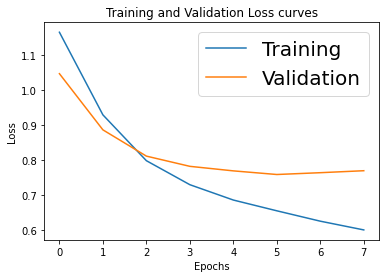

In [59]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(loss_plot, label='Training')
ax.plot(val_loss_plot, label='Validation')
plt.title('Training and Validation Loss curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
ax.legend(prop={'size': 20})
plt.show()

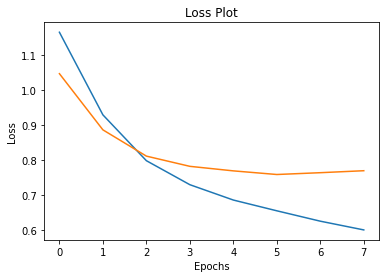

In [60]:
plt.plot(loss_plot)
plt.plot(val_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [61]:
# encoder.save("image_caption_encoder")

In [62]:
# decoder.save("image_caption_decoder", save_traces=True)

In [63]:
# encoder = tf.saved_model.load("image_caption_encoder")

In [64]:
# decoder = tf.saved_model.load("image_caption_decoder")

In [65]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))
    encoder.trainable = False
    decoder.trainable = False
    image_features_extract_model.trainable = False
    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [66]:
import cv2

In [67]:
import matplotlib.cm as cm

In [68]:
def plot_attention(image, result, attention_plot):
    len_result = len(result)
    for i in range(len_result):
        interim = attention_plot[i]
        interim /= np.max(interim)
        interim = interim.reshape(8,8)
        interim = np.uint8(255 * interim)
        jet = cm.get_cmap("jet") 
        jet_colors = jet(np.arange(256))[:, :3] 
        jet_heatmap = jet_colors[interim] 
        img = tf.keras.preprocessing.image.load_img(image) 
        img = tf.keras.preprocessing.image.img_to_array(img) 
        jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap) 
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap) 
        superimposed_img = jet_heatmap * 0.6 + img*0.4
        superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
        plt.figure(figsize = (8,8))
        plt.imshow(superimposed_img)
        plt.title(result[i], fontsize = 20)
        plt.show()  

In [69]:
# def plot_attention(image, result, attention_plot):
#     temp_image = np.array(Image.open(image))

#     fig = plt.figure(figsize=(200, 200))

#     len_result = len(result)
#     for i in range(len_result):
#         temp_att = np.resize(attention_plot[i], (8, 8))
#         grid_size = max(np.ceil(len_result/2), 2)
#         ax = fig.add_subplot(grid_size, grid_size, i+1)
#         ax.set_title(result[i], fontsize = 200)
#         img = ax.imshow(temp_image)
#         ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

#     plt.tight_layout()
#     plt.show()
# #     return ax

In [71]:
image = r"C:\Users\vedpi\OneDrive\Desktop\DT.jpg"

In [72]:
image = r"C:\Users\vedpi\OneDrive\Desktop\dad.jpg"

In [73]:
image = r"C:\Users\vedpi\OneDrive\Desktop\two_girls.jpg"

In [74]:
image = r"C:\Users\vedpi\OneDrive\Desktop\GG.jpg"

In [75]:
# image = r"C:\Users\vedpi\OneDrive\Desktop\boy_girl.jpg"

In [76]:
image = r"C:\Users\vedpi\OneDrive\Desktop\Seminar\IMG_3657.jpg"

In [77]:
image = r"C:\Users\vedpi\OneDrive\Desktop\Seminar\IMG_2792.jpg"

In [78]:
image = r"C:\Users\vedpi\OneDrive\Desktop\Harry.PNG"

In [87]:
image = r"C:\Users\vedpi\OneDrive\Desktop\baseball.jpeg"

In [97]:
image = r"C:\Users\vedpi\OneDrive\Desktop\unl_building.png"

In [102]:
image = r"C:\Users\vedpi\OneDrive\Desktop\bar_chart.png"

In [106]:
image =r"C:\Users\vedpi\OneDrive\Desktop\trex.png"

In [110]:
clock_image = r"C:\Users\vedpi\OneDrive\Desktop\clock.png"

In [107]:
attention_features_shape = 64

In [111]:
result, attention_plot = evaluate(clock_image)

Prediction Caption: a tall buildings and the london on it <end>


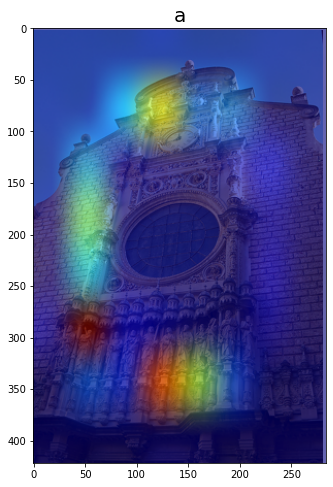

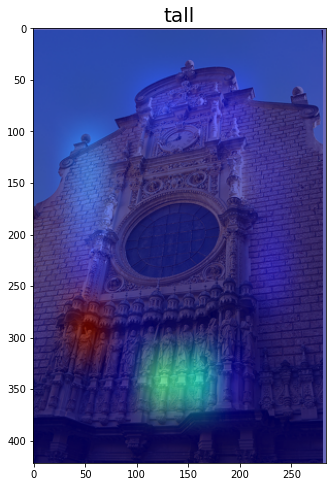

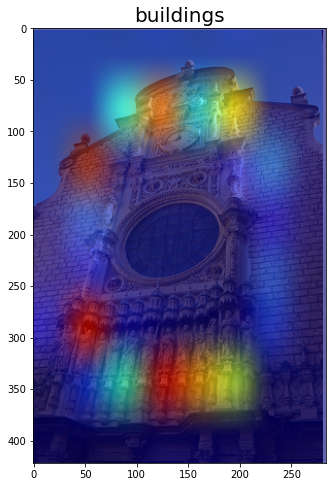

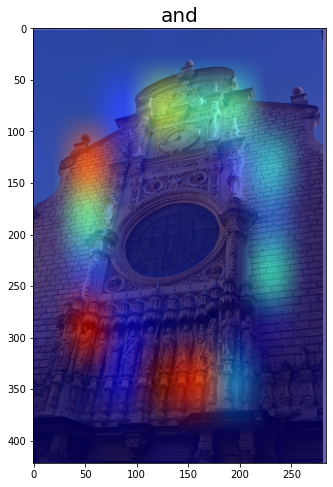

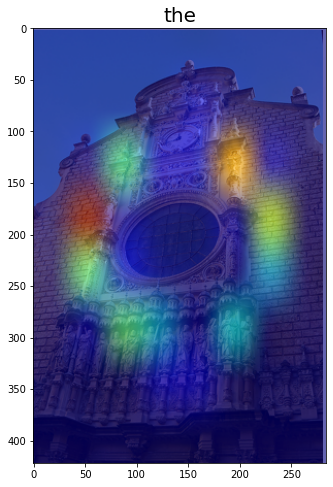

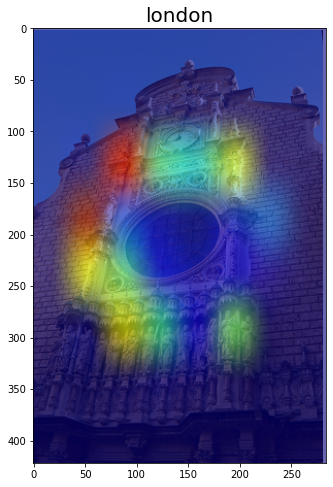

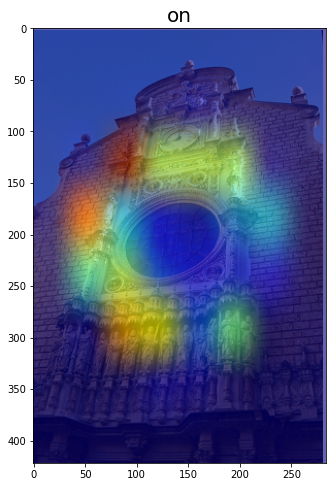

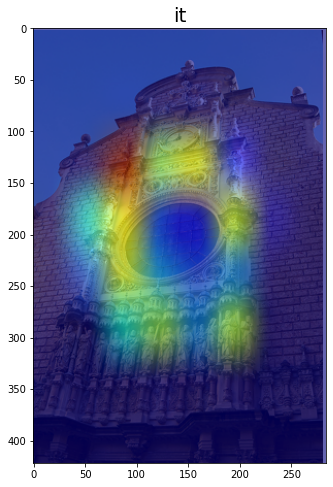

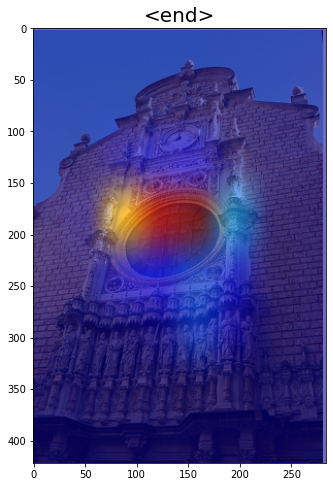

In [113]:
print('Prediction Caption:', ' '.join(result))
plot_attention(clock_image, result, attention_plot)

In [ ]:
img = tf.keras.preprocessing.image.load_img(image) 
img = tf.keras.preprocessing.image.img_to_array(img) 

In [ ]:
img.shape

In [ ]:
R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]

In [ ]:
tf.keras.preprocessing.image.load_img(image) 

In [ ]:
plt.imshow(R, cmap = "Reds")

In [ ]:
plt.imshow(R, cmap = "Greens")

In [ ]:
plt.imshow(R, cmap = "Blues")

In [ ]:
image = r'C:\\Users\\vedpi\\train2014\\COCO_train2014_000000362046.jpg'

In [ ]:
# load the image with the required shape
img = tf.keras.preprocessing.image.load_img(image, target_size=(224, 224))

In [ ]:
# convert the image to an array
img = tf.keras.preprocessing.image.img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = np.expand_dims(img, axis=0)

In [ ]:
baseModel = tf.keras.applications.VGG16(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')


In [ ]:
input_image = tf.keras.layers.Input(shape = (224,224,3))

In [ ]:
preprocessing = tf.keras.layers.Lambda(lambda x: tf.keras.applications.vgg16.preprocess_input(x))(input_image)

In [ ]:
baseModel.summary()

In [ ]:
top = baseModel(preprocessing)

In [ ]:
model = tf.keras.models.Model(input_image, top)

In [ ]:
model.summary()

In [ ]:
# redefine model to output right after the first hidden layer
ixs = [1]
outputs = [model.layers[2].layers[i].output for i in ixs]

In [ ]:
model_visual = tf.keras.models.Model(inputs=model.layers[2].input, outputs=outputs)

In [ ]:
model_visual.summary()

In [ ]:
feature_maps = model_visual.predict(img)

In [ ]:
feature_maps.shape

In [ ]:
fmap.shape

In [ ]:
# plot the output from each block
plt.rcParams["figure.figsize"] = (10,10)
square = 2
counter = 0
for fmap in feature_maps:
    # plot all 36 maps in an 6x6 squares
    ix = 1
#     print("feature maps from block" + str(i) + "convolutional layer")
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            
            plt.imshow(fmap[:, :, ix-1], cmap='gray')
#             pyplot.title("feature maps from block" + str(i) + "convolutional layer")
            ix += 1
#             pyplot.title("feature maps from block" + str(i) + "convolutional layer")
    # show the figure
    counter = counter + 1
    print("feature maps from block " + str(counter) + " convolutional layer")
#     pyplot.title("feature maps from block" + str(counter) + "convolutional layer", loc = "left")
    plt.show()

In [ ]:
tf.keras.preprocessing.image.load_img(image) 

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
img = plot_attention(image, result, attention_plot)

In [ ]:
# # test_img = cv2.imread(image)/255.0

# # fig = plt.figure(figsize=(200, 200))

# len_result = len(result)
# for i in range(len_result):
#     interim = attention_plot[i]
#     interim /= np.max(interim)
#     interim = interim.reshape(8,8)
#     interim = np.uint8(255 * interim)
#     jet = cm.get_cmap("jet") 
#     jet_colors = jet(np.arange(256))[:, :3] 
#     jet_heatmap = jet_colors[interim] 
#     img = tf.keras.preprocessing.image.load_img(image) 
#     img = tf.keras.preprocessing.image.img_to_array(img) 
#     jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap) 
#     jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
#     jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap) 
#     superimposed_img = jet_heatmap * 0.4 + img 
#     superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
#     plt.imshow(superimposed_img)
#     plt.title(result[i], fontsize = 50)
#     plt.show()
# #     ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

In [ ]:
decoder.get_weights()[0].shape

In [ ]:
# decoder.get_weights()[0][1:,:].shape

In [ ]:
import pandas as pd

In [ ]:
tokenizer.word_index

In [ ]:
tokenizer_df = pd.DataFrame(dict(tokenizer.word_index), index = [1]).T.reset_index()

In [ ]:
tokenizer_df.columns = ["word", "index"]

In [ ]:
tokenizer_df = tokenizer_df.sort_values("index").reset_index(drop = True)

In [ ]:
tokenizer_df.iloc[:6000,:]

In [ ]:
from sklearn.decomposition import PCA

embedding = PCA(n_components=3)

X_transformed = embedding.fit_transform(decoder.get_weights()[0])

X_transformed.shape



In [ ]:
df = pd.DataFrame(X_transformed)

words = pd.DataFrame(list(tokenizer_df.iloc[:6000,:]["word"]))

In [ ]:
words.columns = ["word"]

df = pd.concat([df, words],1)

df


In [ ]:
import plotly.express as px

In [ ]:
fig = px.scatter_3d(df.sample(500), x=0, y=1, z=2,
              text='word')
fig.write_html("word_embs_captioning.html")
fig.show()